In [1]:
# Import the libraries needed for the project
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # transform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!pip -q install folium
import folium # map rendering library

print('Libraries downloaded!')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    ca-certificates-2020.6.20  |       hecda079_0         145 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-2.0.0                |     pyh9f0ad1d_0          63 KB  conda-forge
    openssl-1.1.1g             |       h516909a_1         2.1 MB  conda-forge
    certifi-2020.6.20          |   py36h9f0ad1d_0         151 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTALLED:

    geographiclib:   1.50-py_0          conda-forge
    geopy:           

In [2]:
CLIENT_ID = 'QQK5BE4GNRNEI04RLQBVW0XK5V33XNPXL1JTOTGIU2NH24IW' # your Foursquare ID
CLIENT_SECRET = '2TSXP51FGZZBLJJU3VADO0ZLCKAFDLDXSTYM01LFAAPRKRFW' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 50
radius = 250

print('Your credentials:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentials:
CLIENT_ID: QQK5BE4GNRNEI04RLQBVW0XK5V33XNPXL1JTOTGIU2NH24IW
CLIENT_SECRET:2TSXP51FGZZBLJJU3VADO0ZLCKAFDLDXSTYM01LFAAPRKRFW


# Data gathering and wrangling 

## 1. Singapore data 

In [3]:
# Download the postal district table from Wikipedia and transform into a dataframe
url_sin = 'https://en.wikipedia.org/wiki/Postal_codes_in_Singapore#Postal_districts'

df_sin = pd.read_html(url_sin, header=0)[0]
df_sin.drop(['Postal sector(1st 2 digits of 6-digit postal codes)', 'Postal district'], axis = 1, inplace=True)
df_sin.head()

,General location
0,"Raffles Place, Cecil, Marina, People's Park"
1,"Anson, Tanjong Pagar"
2,"Bukit Merah, Queenstown, Tiong Bahru"
3,"Telok Blangah, Harbourfront"
4,"Pasir Panjang, Hong Leong Garden, Clementi New..."


In [4]:
# Take the 'General location' column as the neighborhood names

# 1 - Reindex and repeat cols on len of split and reset index
df_sin1 = df_sin.reindex(df_sin.index.repeat(df_sin['General location'].fillna("").str.split(',').apply(len)))
df_sin1.head(10)

,General location
0,"Raffles Place, Cecil, Marina, People's Park"
0,"Raffles Place, Cecil, Marina, People's Park"
0,"Raffles Place, Cecil, Marina, People's Park"
0,"Raffles Place, Cecil, Marina, People's Park"
1,"Anson, Tanjong Pagar"
1,"Anson, Tanjong Pagar"
2,"Bukit Merah, Queenstown, Tiong Bahru"
2,"Bukit Merah, Queenstown, Tiong Bahru"
2,"Bukit Merah, Queenstown, Tiong Bahru"
3,"Telok Blangah, Harbourfront"


In [5]:
df_sin1 = df_sin.drop(['General location'],1)

In [6]:
# 2 - Splitting the column contents into separate rows
s = df_sin['General location'].str.split(',', expand=True).stack().reset_index(level=1,drop=True)
s

0          Raffles Place
0                  Cecil
0                 Marina
0          People's Park
1                  Anson
1          Tanjong Pagar
2            Bukit Merah
2             Queenstown
2            Tiong Bahru
3          Telok Blangah
3           Harbourfront
4          Pasir Panjang
4      Hong Leong Garden
4      Clementi New Town
5            High Street
5      Beach Road (part)
6            Middle Road
6            Golden Mile
7           Little India
7            Farrer Park
7            Jalan Besar
7               Lavender
8                Orchard
8              Cairnhill
8           River Valley
9                Ardmore
9            Bukit Timah
9           Holland Road
9                Tanglin
10         Watten Estate
10                Novena
10               Thomson
11             Balestier
11             Toa Payoh
11             Serangoon
12            Macpherson
12              Braddell
13               Geylang
13                 Eunos
13              Aljunied


In [7]:
# 3 - Group the series and df using cumcount.
df_sin1 = df_sin1.set_index(df_sin1.groupby(df_sin1.index).cumcount(), append=True)
s = s.to_frame('General location').set_index(s.groupby(s.index).cumcount(), append=True)
s

General location
0  0       Raffles Place
   1               Cecil
   2              Marina
   3       People's Park
1  0               Anson
   1       Tanjong Pagar
2  0         Bukit Merah
   1          Queenstown
   2         Tiong Bahru
3  0       Telok Blangah
   1        Harbourfront
4  0       Pasir Panjang
   1   Hong Leong Garden
   2   Clementi New Town
5  0         High Street
   1   Beach Road (part)
6  0         Middle Road
   1         Golden Mile
7  0        Little India
   1         Farrer Park
   2         Jalan Besar
   3            Lavender
8  0             Orchard
   1           Cairnhill
   2        River Valley
9  0             Ardmore
   1         Bukit Timah
   2        Holland Road
   3             Tanglin
10 0       Watten Estate
   1              Novena
   2             Thomson
11 0           Balestier
   1           Toa Payoh
   2           Serangoon
12 0          Macpherson
   1            Braddell
13 0             Geylang
   1               Eunos
   2            Aljunied
14 0              Katong
   1           Joo Chiat
   2          Amber Road
15 0               Bedok
   1    Upper East Coast
   2            Eastwood
   3           Kew Drive
16 0              Loyang
   1              Changi
17 0               Simei
   1            Tampines
   2           Pasir Ris
18 0    Serangoon Garden
   1             Hougang
   2             Punggol
19 0              Bishan
   1          Ang Mo Kio
20 0   Upper Bukit Timah
   1       Clementi Park
   2          Ulu Pandan
21 0             Penjuru
   1              Jurong
   2             Pioneer
   3                Tuas
22 0            Hillview
   1          Dairy Farm
   2       Bukit Panjang
   3       Choa Chu Kang
23 0        Lim Chu Kang
   1              Tengah
24 0              Kranji
   1           Woodgrove
   2           Woodlands
25 0       Upper Thomson
   1          Springleaf
26 0              Yishun
   1           Sembawang
   2              Senoko
27 0             Seletar

In [8]:
# 4 - Join all of them together and reset index.
df_sin1 = df_sin1.join(s, how='outer').reset_index(level=[0,1],drop=True)
df_sin1

,General location
0,Raffles Place
1,Cecil
2,Marina
3,People's Park
4,Anson
5,Tanjong Pagar
6,Bukit Merah
7,Queenstown
8,Tiong Bahru
9,Telok Blangah


In [9]:
df_sin1["General location"] = df_sin1["General location"].str.replace(r" \(.*\)","")
df_sin1.rename(columns={'General location': 'Neighborhood', 'Country': 'Country', 'Address': 'Address'}, inplace=True)
df_sin1

,Neighborhood
0,Raffles Place
1,Cecil
2,Marina
3,People's Park
4,Anson
5,Tanjong Pagar
6,Bukit Merah
7,Queenstown
8,Tiong Bahru
9,Telok Blangah


In [10]:
df_sin1['Country'] = "Singapore"
df_sin1['Address'] = df_sin1['Neighborhood'] + ", " + df_sin1['Country']
df_sin1.replace(to_replace='Hong Leong Garden, Singapore', value='106 West Coast Way, Singapore 127046', regex=True, inplace=True)
df_sin1.replace(to_replace='Beach Road (part), Singapore', value='Beach Road, Singapore', regex=True, inplace=True)
df_sin1

,Neighborhood,Country,Address
0,Raffles Place,Singapore,"Raffles Place, Singapore"
1,Cecil,Singapore,"Cecil, Singapore"
2,Marina,Singapore,"Marina, Singapore"
3,People's Park,Singapore,"People's Park, Singapore"
4,Anson,Singapore,"Anson, Singapore"
5,Tanjong Pagar,Singapore,"Tanjong Pagar, Singapore"
6,Bukit Merah,Singapore,"Bukit Merah, Singapore"
7,Queenstown,Singapore,"Queenstown, Singapore"
8,Tiong Bahru,Singapore,"Tiong Bahru, Singapore"
9,Telok Blangah,Singapore,"Telok Blangah, Singapore"


In [11]:
# Use Geopy library to add the latitude and longitude information for each neighborhood
from geopy.extra.rate_limiter import RateLimiter
geolocator = Nominatim(user_agent="sin_explorer")

# 1 - convenient function to delay between geocoding calls
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)
# 2 - create location column
df_sin1['Location'] = df_sin1['Address'].apply(geocode)
# 3 - create longitude, latitude, altitude from location column (returns tuple)
df_sin1['Point'] = df_sin1['Location'].apply(lambda loc: tuple(loc.point) if loc else None)
# 4 - split point column into latitude, longitude columns
df_sin1[['Latitude', 'Longitude', 'Altitude']] = pd.DataFrame(df_sin1['Point'].tolist(), index=df_sin1.index)
df_sin1

,Neighborhood,Country,Address,Location,Point,Latitude,Longitude,Altitude
0,Raffles Place,Singapore,"Raffles Place, Singapore","(Raffles Place, Malacca Street, Downtown Core,...","(1.2835416999999998, 103.85146023266938, 0.0)",1.283542,103.851460,0.0
1,Cecil,Singapore,"Cecil, Singapore","(Cecil Street, Downtown Core, Singapore, Centr...","(1.2769552, 103.847016, 0.0)",1.276955,103.847016,0.0
2,Marina,Singapore,"Marina, Singapore","(Singapore, Central, 178957, Singapore, (1.290...","(1.2904753, 103.8520359, 0.0)",1.290475,103.852036,0.0
3,People's Park,Singapore,"People's Park, Singapore","(People's Park, 101, Upper Cross Street, China...","(1.2858105, 103.8441598, 0.0)",1.285810,103.844160,0.0
4,Anson,Singapore,"Anson, Singapore","(Anson Road, Downtown Core, Singapore, Central...","(1.276629, 103.8472472, 0.0)",1.276629,103.847247,0.0
5,Tanjong Pagar,Singapore,"Tanjong Pagar, Singapore","(Tanjong Pagar, 120, Maxwell Road, Downtown Co...","(1.27660565, 103.84577931609854, 0.0)",1.276606,103.845779,0.0
6,Bukit Merah,Singapore,"Bukit Merah, Singapore","(Bukit Merah, Singapore, Central, Singapore, (...","(1.2704395, 103.82831840176755, 0.0)",1.270439,103.828318,0.0
7,Queenstown,Singapore,"Queenstown, Singapore","(Queenstown, 301, Commonwealth Avenue, Nepal H...","(1.2946226, 103.8060366, 0.0)",1.294623,103.806037,0.0
8,Tiong Bahru,Singapore,"Tiong Bahru, Singapore","(Tiong Bahru, 300, Tiong Bahru Road, Radin Mas...","(1.28617925, 103.82722523285841, 0.0)",1.286179,103.827225,0.0
9,Telok Blangah,Singapore,"Telok Blangah, Singapore","(Telok Blangah, 463, Telok Blangah Road, Radin...","(1.27102005, 103.80969476655733, 0.0)",1.271020,103.809695,0.0


In [12]:
df_sin1 = df_sin1.drop(['Location', 'Point', 'Altitude'], axis=1)
df_sin1.head()

,Neighborhood,Country,Address,Latitude,Longitude
0,Raffles Place,Singapore,"Raffles Place, Singapore",1.283542,103.851460
1,Cecil,Singapore,"Cecil, Singapore",1.276955,103.847016
2,Marina,Singapore,"Marina, Singapore",1.290475,103.852036
3,People's Park,Singapore,"People's Park, Singapore",1.285810,103.844160
4,Anson,Singapore,"Anson, Singapore",1.276629,103.847247


In [13]:
print('Singapore has {} neighborhoods.'.format(df_sin1.shape[0]))

Singapore has 79 neighborhoods.


In [14]:
address_sin = 'Singapore'

geolocator = Nominatim(user_agent="sin_explorer")
location_sin = geolocator.geocode(address_sin)
latitude_sin = location_sin.latitude
longitude_sin = location_sin.longitude
print('The geograpical coordinates of Singapore are {}, {}.'.format(latitude_sin, longitude_sin))

The geograpical coordinates of Singapore are 1.3408630000000001, 103.83039182212079.


In [15]:
# create map of Singapore with its neighborhoods using latitude and longitude values
map_sin = folium.Map(location=[latitude_sin, longitude_sin], tiles='cartodbpositron', zoom_start=12)

for lat, lon, poi in zip(df_sin1['Latitude'], df_sin1['Longitude'], df_sin1['Neighborhood']):
    label = folium.Popup(str(poi), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        fill=True,
        fill_opacity=0.7
    ).add_to(map_sin)
    
map_sin

In [16]:
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            latitude_sin, 
            longitude_sin, 
            radius, 
            LIMIT)
    
# make the GET request
results = requests.get(url).json()['response']
results

{'warning': {'text': "There aren't a lot of results near you. Try something more general, reset your filters, or expand the search area."},
 'headerLocation': 'Central Catchment Nature Reserve',
 'headerFullLocation': 'Central Catchment Nature Reserve, Singapore',
 'headerLocationGranularity': 'neighborhood',
 'totalResults': 2,
 'suggestedBounds': {'ne': {'lat': 1.3431130022500024,
   'lng': 103.83263823848499},
  'sw': {'lat': 1.3386129977499979, 'lng': 103.82814540575659}},
 'groups': [{'type': 'Recommended Places',
   'name': 'recommended',
   'items': [{'reasons': {'count': 0,
      'items': [{'summary': 'This spot is popular',
        'type': 'general',
        'reasonName': 'globalInteractionReason'}]},
     'venue': {'id': '516e7cbde4b08ec9740b6e6d',
      'name': 'Macritchie Reservoir Submerged Boardwalk',
      'location': {'address': 'MacRitchie Reservoir Park',
       'crossStreet': 'Next to Zig-Zag Bridge',
       'lat': 1.3414503424102513,
       'lng': 103.8320276278633,

In [17]:
def getVenues(names, latitudes, longitudes):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        
    # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
        # make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        for v in results:
            venues_list.append((
                name,
                lat,
                lng,
                v['venue']['name'],
                v['venue']['location']['lat'],
                v['venue']['location']['lng'],
                v['venue']['categories'][0]['name']))
        
    # Creating the dataframe with venues
    nearby_venues  = pd.DataFrame(data=venues_list)
    nearby_venues.columns = ['Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude', 'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category']
    
    print(nearby_venues.shape)
    return(nearby_venues)

In [18]:
sin_venues = getVenues(names=df_sin1['Neighborhood'], latitudes=df_sin1['Latitude'], longitudes=df_sin1['Longitude'])

Raffles Place
 Cecil
 Marina
 People's Park
Anson
 Tanjong Pagar
Bukit Merah
 Queenstown
 Tiong Bahru
Telok Blangah
 Harbourfront
Pasir Panjang
 Hong Leong Garden
 Clementi New Town
High Street
 Beach Road
Middle Road
 Golden Mile
Little India
 Farrer Park
 Jalan Besar
 Lavender
Orchard
 Cairnhill
 River Valley
Ardmore
 Bukit Timah
 Holland Road
 Tanglin
Watten Estate
 Novena
 Thomson
Balestier
 Toa Payoh
 Serangoon
Macpherson
 Braddell
Geylang
 Eunos
 Aljunied
Katong
 Joo Chiat
 Amber Road
Bedok
 Upper East Coast
 Eastwood
 Kew Drive
Loyang
 Changi
Simei
 Tampines
 Pasir Ris
Serangoon Garden
 Hougang
 Punggol
Bishan
 Ang Mo Kio
Upper Bukit Timah
 Clementi Park
 Ulu Pandan
Penjuru
 Jurong
 Pioneer
 Tuas
Hillview
 Dairy Farm
 Bukit Panjang
 Choa Chu Kang
Lim Chu Kang
 Tengah
Kranji
 Woodgrove
 Woodlands
Upper Thomson
 Springleaf
Yishun
 Sembawang
 Senoko
Seletar
(1442, 7)


In [19]:
sin_venues

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Raffles Place,1.283542,103.851460,The Fullerton Bay Hotel,1.283878,103.853314,Hotel
1,Raffles Place,1.283542,103.851460,City Hot Pot,1.284173,103.851585,Hotpot Restaurant
2,Raffles Place,1.283542,103.851460,CULINARYON,1.284876,103.850933,Comfort Food Restaurant
3,Raffles Place,1.283542,103.851460,Virgin Active,1.284608,103.850815,Gym / Fitness Center
4,Raffles Place,1.283542,103.851460,1-Altitude,1.284794,103.851151,Cocktail Bar
5,Raffles Place,1.283542,103.851460,Fitness First Platinum,1.283970,103.850433,Gym / Fitness Center
6,Raffles Place,1.283542,103.851460,The Salad Shop,1.285523,103.851177,Salad Place
7,Raffles Place,1.283542,103.851460,The Tower Club,1.282886,103.851112,Lounge
8,Raffles Place,1.283542,103.851460,Fitness First Platinum,1.282114,103.852131,Gym / Fitness Center
9,Raffles Place,1.283542,103.851460,La Brasserie,1.283113,103.853311,Café


In [20]:
# Check out how many of the nearby venues are in each neighborhood of Singapore
sin_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Aljunied,10,10,10,10,10,10
Amber Road,5,5,5,5,5,5
Ang Mo Kio,26,26,26,26,26,26
Beach Road,19,19,19,19,19,19
Braddell,5,5,5,5,5,5
Bukit Panjang,22,22,22,22,22,22
Bukit Timah,5,5,5,5,5,5
Cairnhill,2,2,2,2,2,2
Cecil,35,35,35,35,35,35


In [21]:
# Find out how many of each venue category is present in Singapore
sin_categories_grouped = sin_venues.groupby('Venue Category').count()
sin_categories_grouped.drop(['Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude', 'Venue Latitude', 'Venue Longitude'], axis=1,inplace=True)
sin_categories_grouped.sort_values(by='Venue',ascending=False, inplace=True)
sin_categories_grouped

,Venue
Venue Category,
Coffee Shop,80
Chinese Restaurant,68
Japanese Restaurant,59
Café,52
Food Court,50
Bakery,49
Asian Restaurant,40
Fast Food Restaurant,37
Shopping Mall,35


In [22]:
# Display the venue categories in a horizontal bar chart
import matplotlib.pyplot as plt

ax = sin_categories_grouped.plot(kind='barh', figsize=(20, 38), color='#86bf91', zorder=2, width=0.9)
ax.set_ylabel('Venue Category')
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Number of Venues')
ax.set_title('Venue Categories in Singapore')

plt.show()

<Figure size 2000x3800 with 1 Axes>

In [23]:
# Show the unique Venue Category names
sin_venues['Venue Category'].unique()[:50]

array(['Hotel', 'Hotpot Restaurant', 'Comfort Food Restaurant',
       'Gym / Fitness Center', 'Cocktail Bar', 'Salad Place', 'Lounge',
       'Café', 'Modern European Restaurant', 'Japanese Restaurant',
       'Chinese Restaurant', 'Seafood Restaurant', 'French Restaurant',
       'Building', 'Hotel Bar', 'Asian Restaurant', 'Coffee Shop',
       'Bakery', 'Kebab Restaurant', 'Ramen Restaurant', 'Restaurant',
       'Mexican Restaurant', 'Shopping Mall', 'Italian Restaurant',
       'Burrito Place', 'Spanish Restaurant', 'Korean Restaurant',
       'Sports Bar', 'Juice Bar', 'Soup Place', 'Sushi Restaurant',
       'Thai Restaurant', 'Art Gallery', 'Concert Hall', 'Event Space',
       'Park', 'Monument / Landmark', 'Bar', 'Club House',
       'Burmese Restaurant', 'Music Store', 'Indian Restaurant',
       'Cosmetics Shop', 'Hostel', 'Dumpling Restaurant', 'Food Court',
       'Noodle House', 'Spa', 'BBQ Joint', 'Flea Market'], dtype=object)

In [24]:
print('There are {} unique categories.'.format(len(sin_venues['Venue Category'].unique())))

There are 201 unique categories.


In [25]:
sin_categories_grouped_transport = sin_categories_grouped.loc[['Bus Station', 'Bus Line', 'Metro Station', 'Bus Stop', 'Train Station','Light Rail Station']]
sin_categories_grouped_transport

,Venue
Venue Category,
Bus Station,15
Bus Line,5
Metro Station,7
Bus Stop,8
Train Station,3
Light Rail Station,1


In [26]:
sin_categories_grouped_outdoors = sin_categories_grouped.loc[['Trail', 'Park', 'Scenic Lookout', 'Playground', 'Garden', 'Other Great Outdoors', 'Outdoors & Recreation', 'Beach']]
sin_categories_grouped_outdoors

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  if __name__ == '__main__':


,Venue
Venue Category,
Trail,5.0
Park,8.0
Scenic Lookout,4.0
Playground,4.0
Garden,1.0
Other Great Outdoors,NaN
Outdoors & Recreation,NaN
Beach,NaN


In [27]:
# Study the neighborhoods

# one hot encoding of the venues' category names
sin_onehot = pd.get_dummies(sin_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
sin_onehot['Neighborhood'] = sin_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [sin_onehot.columns[-1]] + list(sin_onehot.columns[:-1])
sin_onehot = sin_onehot[fixed_columns]

sin_onehot.head()

,Yoga Studio,Accessories Store,American Restaurant,Arcade,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,Bar,Baseball Stadium,Basketball Court,Bed & Breakfast,Beer Garden,Betting Shop,Bike Rental / Bike Share,Bistro,Bookstore,Boutique,Breakfast Spot,Bubble Tea Shop,Buffet,Building,Burger Joint,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Cafeteria,Café,Candy Store,Cantonese Restaurant,Chinese Breakfast Place,Chinese Restaurant,Chocolate Shop,Churrascaria,Clothing Store,Club House,Cocktail Bar,Coffee Shop,Comfort Food Restaurant,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Cupcake Shop,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Event Space,Farm,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,Gay Bar,German Restaurant,Gift Shop,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hainan Restaurant,Halal Restaurant,Harbor / Marina,Hill,Hobby Shop,Hong Kong Restaurant,Hostel,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Light Rail Station,Lottery Retailer,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Music Store,Music Venue,Neighborhood,Night Market,Nightclub,Noodle House,North Indian Restaurant,Optical Shop,Other Repair Shop,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Café,Pet Store,Pharmacy,Pie Shop,Pizza Place,Playground,Plaza,Pool,Pool Hall,Portuguese Restaurant,Post Office,Pub,Public Art,Racetrack,Ramen Restaurant,Record Shop,Rest Area,Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shaanxi Restaurant,Shabu-Shabu Restaurant,Shoe Store,Shopping Mall,Smoke Shop,Snack Place,Soba Restaurant,Soup Place,South Indian Restaurant,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Steakhouse,Supermarket,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Used Auto Dealership,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Waterfront,Whisky Bar,Wine Bar,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Raffles Place,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Raffles Place,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Raffles Place,0,

In [28]:
# Group rows by neighborhood and by taking the mean of the frequency of occurrence of each category
sin_venues_grouped = sin_onehot.groupby('Neighborhood').mean().reset_index()
sin_venues_grouped

,Neighborhood,Yoga Studio,Accessories Store,American Restaurant,Arcade,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,Bar,Baseball Stadium,Basketball Court,Bed & Breakfast,Beer Garden,Betting Shop,Bike Rental / Bike Share,Bistro,Bookstore,Boutique,Breakfast Spot,Bubble Tea Shop,Buffet,Building,Burger Joint,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Cafeteria,Café,Candy Store,Cantonese Restaurant,Chinese Breakfast Place,Chinese Restaurant,Chocolate Shop,Churrascaria,Clothing Store,Club House,Cocktail Bar,Coffee Shop,Comfort Food Restaurant,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Cupcake Shop,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Event Space,Farm,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,Gay Bar,German Restaurant,Gift Shop,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hainan Restaurant,Halal Restaurant,Harbor / Marina,Hill,Hobby Shop,Hong Kong Restaurant,Hostel,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Light Rail Station,Lottery Retailer,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Music Store,Music Venue,Night Market,Nightclub,Noodle House,North Indian Restaurant,Optical Shop,Other Repair Shop,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Café,Pet Store,Pharmacy,Pie Shop,Pizza Place,Playground,Plaza,Pool,Pool Hall,Portuguese Restaurant,Post Office,Pub,Public Art,Racetrack,Ramen Restaurant,Record Shop,Rest Area,Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shaanxi Restaurant,Shabu-Shabu Restaurant,Shoe Store,Shopping Mall,Smoke Shop,Snack Place,Soba Restaurant,Soup Place,South Indian Restaurant,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Steakhouse,Supermarket,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Used Auto Dealership,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Waterfront,Whisky Bar,Wine Bar,Wings Joint,Women's Store
0,Aljunied,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.100000,0.000000,0.000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,

In [29]:
sin_venues_grouped.shape

(73, 201)

In [30]:
# Print each neighborhood along with the top 5 most common venues
num_top_venues = 5

for hood in sin_venues_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = sin_venues_grouped[sin_venues_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

---- Aljunied----
                           venue  freq
0  Vegetarian / Vegan Restaurant   0.2
1            Japanese Restaurant   0.1
2                    Coffee Shop   0.1
3             Seafood Restaurant   0.1
4                     Steakhouse   0.1


---- Amber Road----
                venue  freq
0          Club House   0.2
1            Bus Stop   0.2
2                Café   0.2
3  Chinese Restaurant   0.2
4                 Bar   0.2


---- Ang Mo Kio----
                 venue  freq
0         Dessert Shop  0.12
1          Snack Place  0.08
2  Japanese Restaurant  0.08
3      Bubble Tea Shop  0.08
4            Multiplex  0.04


---- Beach Road----
                   venue  freq
0  Vietnamese Restaurant  0.16
1           Dessert Shop  0.11
2             Food Court  0.11
3  Indonesian Restaurant  0.05
4                  Hotel  0.05


---- Braddell----
                  venue  freq
0           Bus Station   0.2
1            Food Court   0.2
2                Bakery   0.2
3  Fast Food R

          venue  freq
0   Coffee Shop  0.42
1  Betting Shop  0.08
2     Pool Hall  0.08
3          Café  0.08
4  Noodle House  0.08


---- Ulu Pandan----
                   venue  freq
0    Japanese Restaurant  0.14
1           Dessert Shop  0.07
2  Performing Arts Venue  0.07
3          Shopping Mall  0.07
4        Bubble Tea Shop  0.07


---- Upper East Coast----
                venue  freq
0  Chinese Restaurant  0.14
1   Indian Restaurant  0.10
2         Bus Station  0.05
3      Massage Studio  0.05
4            Dive Bar  0.05


---- Woodgrove----
                 venue  freq
0           Food Court  0.11
1          Supermarket  0.11
2        Deli / Bodega  0.11
3          Pizza Place  0.11
4  Fried Chicken Joint  0.11


---- Woodlands----
                 venue  freq
0  Japanese Restaurant  0.09
1                 Café  0.07
2        Shopping Mall  0.07
3    Electronics Store  0.04
4       Clothing Store  0.04


----Anson----
                  venue  freq
0           Coffee Shop  0.2

In [31]:
# Function to sort venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [84]:
# Discover the top 10 venues' category types of each neighborhood of Scarborough
import numpy as np 

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = sin_venues_grouped['Neighborhood']

for ind in np.arange(sin_venues_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(sin_venues_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head(15)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Aljunied,Vegetarian / Vegan Restaurant,Coffee Shop,Steakhouse,Martial Arts School,Dim Sum Restaurant,Seafood Restaurant,Japanese Restaurant,Kitchen Supply Store,Train Station,Fish & Chips Shop
1,Amber Road,Bus Stop,Café,Chinese Restaurant,Club House,Bar,Women's Store,Fish & Chips Shop,French Restaurant,Food Stand,Food Court
2,Ang Mo Kio,Dessert Shop,Japanese Restaurant,Snack Place,Bubble Tea Shop,Sushi Restaurant,Coffee Shop,Fast Food Restaurant,Multiplex,Sandwich Place,Seafood Restaurant
3,Beach Road,Vietnamese Restaurant,Food Court,Dessert Shop,Hotel,Coffee Shop,Burger Joint,Café,Multiplex,Taiwanese Restaurant,Thai Restaurant
4,Braddell,Fast Food Restaurant,Bus Station,Food Court,Metro Station,Bakery,Filipino Restaurant,French Restaurant,Food Stand,Food & Drink Shop,Food
5,Bukit Panjang,Fast Food Restaurant,Bubble Tea Shop,Sushi Restaurant,American Restaurant,Café,Fried Chicken Joint,Noodle House,Coffee Shop,Lottery Retailer,Shopping Mall
6,Bukit Timah,Trail,Scenic Lookout,Hill,Rest Area,Women's Store,Food Court,Food & Drink Shop,Food,Flower Shop,Flea Market
7,Cairnhill,Accessories Store,Gay Bar,Women's Store,Filipino Restaurant,Fried Chicken Joint,French Restaurant,Food Stand,Food Court,Food & Drink Shop,Food
8,Cecil,Coffee Shop,Japanese Restaurant,Gym / Fitness Center,Salad Place,Chinese Restaurant,Soup Place,Seafood Restaurant,Café,Mexican Restaurant,Shopping Mall
9,Choa Chu Kang,Coffee Shop,Fast Food Restaurant,Smoke Shop,Kids Store,Café,Sandwich Place,Bubble Tea Shop,Sushi Restaurant,Bookstore,Clothing Store


### K-Means Clustering of Singapore neighborhoods

In [85]:
# set number of clusters
kclusters = 5

sin_grouped_clustering = sin_venues_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(sin_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([4, 4, 4, 4, 4, 4, 2, 4, 4, 4], dtype=int32)

In [86]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

sin_merged = df_sin1

# merge nyc_grouped with df_nyc to add latitude/longitude for each neighborhood
sin_merged = sin_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

sin_merged.head(15) # check the last columns!

,Neighborhood,Country,Address,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Raffles Place,Singapore,"Raffles Place, Singapore",1.283542,103.851460,4.0,Gym / Fitness Center,Hotel,Salad Place,Hotpot Restaurant,Comfort Food Restaurant,Café,Modern European Restaurant,Building,Chinese Restaurant,Seafood Restaurant
1,Cecil,Singapore,"Cecil, Singapore",1.276955,103.847016,4.0,Coffee Shop,Japanese Restaurant,Gym / Fitness Center,Salad Place,Chinese Restaurant,Soup Place,Seafood Restaurant,Café,Mexican Restaurant,Shopping Mall
2,Marina,Singapore,"Marina, Singapore",1.290475,103.852036,4.0,Concert Hall,Asian Restaurant,Event Space,Indian Restaurant,French Restaurant,Shopping Mall,Burmese Restaurant,Music Store,Club House,Restaurant
3,People's Park,Singapore,"People's Park, Singapore",1.285810,103.844160,4.0,Noodle House,Food Court,Hostel,Thai Restaurant,Bubble Tea Shop,Fast Food Restaurant,Chinese Restaurant,Coffee Shop,Café,BBQ Joint
4,Anson,Singapore,"Anson, Singapore",1.276629,103.847247,4.0,Coffee Shop,Japanese Restaurant,Salad Place,Gym / Fitness Center,Juice Bar,Restaurant,Sushi Restaurant,Sports Bar,Ramen Restaurant,Fast Food Restaurant
5,Tanjong Pagar,Singapore,"Tanjong Pagar, Singapore",1.276606,103.845779,4.0,Japanese Restaurant,Coffee Shop,Hotel,Bakery,Ramen Restaurant,Gym / Fitness Center,Soup Place,Sports Bar,Spanish Restaurant,Soba Restaurant
6,Bukit Merah,Singapore,"Bukit Merah, Singapore",1.270439,103.828318,4.0,Moving Target,Cafeteria,Harbor / Marina,Fast Food Restaurant,French Restaurant,Food Stand,Food Court,Food & Drink Shop,Food,Flower Shop
7,Queenstown,Singapore,"Queenstown, Singapore",1.294623,103.806037,3.0,Train Station,Women's Store,Farm,French Restaurant,Food Stand,Food Court,Food & Drink Shop,Food,Flower Shop,Flea Market
8,Tiong Bahru,Singapore,"Tiong Bahru, Singapore",1.286179,103.827225,4.0,Chinese Restaurant,Coffee Shop,Sushi Restaurant,Sandwich Place,Bakery,Electronics Store,Fast Food Restaurant,Vegetarian / Vegan Restaurant,Food,Flower Shop
9,Telok Blangah,Singapore,"Telok Blangah, Singapore",1.271020,103.809695,2.0,Bus Station,Bus Stop,Metro Station,Basketball Court,Women's Store,Frozen Yogurt Shop,French Restaurant,Food Stand,Food Court,Food & Drink Shop


In [87]:
sin_merged.shape

(79, 16)

In [88]:
sin_merged.dropna(inplace=True)
sin_merged.shape

(73, 16)

In [89]:
sin_merged_final = sin_merged.astype({'Cluster Labels': 'int32'}, copy=True, errors='ignore', inplace=True)
sin_merged_final

,Neighborhood,Country,Address,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Raffles Place,Singapore,"Raffles Place, Singapore",1.283542,103.851460,4,Gym / Fitness Center,Hotel,Salad Place,Hotpot Restaurant,Comfort Food Restaurant,Café,Modern European Restaurant,Building,Chinese Restaurant,Seafood Restaurant
1,Cecil,Singapore,"Cecil, Singapore",1.276955,103.847016,4,Coffee Shop,Japanese Restaurant,Gym / Fitness Center,Salad Place,Chinese Restaurant,Soup Place,Seafood Restaurant,Café,Mexican Restaurant,Shopping Mall
2,Marina,Singapore,"Marina, Singapore",1.290475,103.852036,4,Concert Hall,Asian Restaurant,Event Space,Indian Restaurant,French Restaurant,Shopping Mall,Burmese Restaurant,Music Store,Club House,Restaurant
3,People's Park,Singapore,"People's Park, Singapore",1.285810,103.844160,4,Noodle House,Food Court,Hostel,Thai Restaurant,Bubble Tea Shop,Fast Food Restaurant,Chinese Restaurant,Coffee Shop,Café,BBQ Joint
4,Anson,Singapore,"Anson, Singapore",1.276629,103.847247,4,Coffee Shop,Japanese Restaurant,Salad Place,Gym / Fitness Center,Juice Bar,Restaurant,Sushi Restaurant,Sports Bar,Ramen Restaurant,Fast Food Restaurant
5,Tanjong Pagar,Singapore,"Tanjong Pagar, Singapore",1.276606,103.845779,4,Japanese Restaurant,Coffee Shop,Hotel,Bakery,Ramen Restaurant,Gym / Fitness Center,Soup Place,Sports Bar,Spanish Restaurant,Soba Restaurant
6,Bukit Merah,Singapore,"Bukit Merah, Singapore",1.270439,103.828318,4,Moving Target,Cafeteria,Harbor / Marina,Fast Food Restaurant,French Restaurant,Food Stand,Food Court,Food & Drink Shop,Food,Flower Shop
7,Queenstown,Singapore,"Queenstown, Singapore",1.294623,103.806037,3,Train Station,Women's Store,Farm,French Restaurant,Food Stand,Food Court,Food & Drink Shop,Food,Flower Shop,Flea Market
8,Tiong Bahru,Singapore,"Tiong Bahru, Singapore",1.286179,103.827225,4,Chinese Restaurant,Coffee Shop,Sushi Restaurant,Sandwich Place,Bakery,Electronics Store,Fast Food Restaurant,Vegetarian / Vegan Restaurant,Food,Flower Shop
9,Telok Blangah,Singapore,"Telok Blangah, Singapore",1.271020,103.809695,2,Bus Station,Bus Stop,Metro Station,Basketball Court,Women's Store,Frozen Yogurt Shop,French Restaurant,Food Stand,Food Court,Food & Drink Shop


In [136]:
# create map
sin_map_clusters = folium.Map(location=[latitude_sin, longitude_sin], tiles='cartodbpositron', zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(sin_merged_final['Latitude'], sin_merged_final['Longitude'], sin_merged_final['Neighborhood'], sin_merged_final['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(sin_map_clusters)
       
sin_map_clusters

## Analyze the clusters

In [91]:
sin_cleanedup = sin_merged_final.sort_values(by=['Cluster Labels'])
sin_cleanedup

,Neighborhood,Country,Address,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
47,Loyang,Singapore,"Loyang, Singapore",1.375368,103.977292,0,Bus Station,Women's Store,Filipino Restaurant,Fried Chicken Joint,French Restaurant,Food Stand,Food Court,Food & Drink Shop,Food,Flower Shop
68,Lim Chu Kang,Singapore,"Lim Chu Kang, Singapore",1.434217,103.714987,1,Farm,Fast Food Restaurant,Fried Chicken Joint,French Restaurant,Food Stand,Food Court,Food & Drink Shop,Food,Flower Shop,Flea Market
77,Senoko,Singapore,"Senoko, Singapore",1.460297,103.805245,2,Shopping Mall,Candy Store,Women's Store,Fast Food Restaurant,Food Stand,Food Court,Food & Drink Shop,Food,Flower Shop,Flea Market
26,Bukit Timah,Singapore,"Bukit Timah, Singapore",1.354690,103.776372,2,Trail,Scenic Lookout,Hill,Rest Area,Women's Store,Food Court,Food & Drink Shop,Food,Flower Shop,Flea Market
65,Dairy Farm,Singapore,"Dairy Farm, Singapore",1.365158,103.774078,2,Public Art,Garden,Trail,Women's Store,Farm,Food Stand,Food Court,Food & Drink Shop,Food,Flower Shop
46,Kew Drive,Singapore,"Kew Drive, Singapore",1.320191,103.951661,2,Food & Drink Shop,Bus Stop,Trail,Women's Store,Fast Food Restaurant,French Restaurant,Food Stand,Food Court,Food,Flower Shop
9,Telok Blangah,Singapore,"Telok Blangah, Singapore",1.271020,103.809695,2,Bus Station,Bus Stop,Metro Station,Basketball Court,Women's Store,Frozen Yogurt Shop,French Restaurant,Food Stand,Food Court,Food & Drink Shop
7,Queenstown,Singapore,"Queenstown, Singapore",1.294623,103.806037,3,Train Station,Women's Store,Farm,French Restaurant,Food Stand,Food Court,Food & Drink Shop,Food,Flower Shop,Flea Market
44,Upper East Coast,Singapore,"Upper East Coast, Singapore",1.310465,103.923513,4,Chinese Restaurant,Indian Restaurant,Bar,Bus Station,Spa,Sandwich Place,Sporting Goods Shop,Massage Studio,Supermarket,Gastropub
53,Hougang,Singapore,"Hougang, Singapore",1.370801,103.892544,4,Fast Food Restaurant,Food Court,Chinese Restaurant,Café,Coffee Shop,Soup Place,Pharmacy,Frozen Yogurt Shop,Metro Station,Sandwich Place


In [92]:
# Check out cluster 1
sin_merged_final.loc[sin_merged_final['Cluster Labels'] == 0, sin_merged_final.columns[[0] + list(range(5, sin_merged_final.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
47,Loyang,0,Bus Station,Women's Store,Filipino Restaurant,Fried Chicken Joint,French Restaurant,Food Stand,Food Court,Food & Drink Shop,Food,Flower Shop


#### Distinguishing characteristics of cluster 1
1. Comprising of only 1 neighborhood: Loyang
2. Foursquare returned only 1 venue: 'Bus stop 98069', with the category 'Bus Station'.

In [93]:
# Check out cluster 2
sin_merged_final.loc[sin_merged_final['Cluster Labels'] == 1, sin_merged_final.columns[[0] + list(range(5, sin_merged_final.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
68,Lim Chu Kang,1,Farm,Fast Food Restaurant,Fried Chicken Joint,French Restaurant,Food Stand,Food Court,Food & Drink Shop,Food,Flower Shop,Flea Market


#### Distinguishing characteristics of cluster 2
1. Comprising of 1 neighborhood: Lim Chu Kang
2. Foursquare returned only 1 venue: 'Neo Cheng Soon Farm', with the category 'Farm'. 

In [94]:
# Check out cluster 3
sin_merged_final.loc[sin_merged_final['Cluster Labels'] == 2, sin_merged_final.columns[[0] + list(range(5, sin_merged_final.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,Telok Blangah,2,Bus Station,Bus Stop,Metro Station,Basketball Court,Women's Store,Frozen Yogurt Shop,French Restaurant,Food Stand,Food Court,Food & Drink Shop
26,Bukit Timah,2,Trail,Scenic Lookout,Hill,Rest Area,Women's Store,Food Court,Food & Drink Shop,Food,Flower Shop,Flea Market
46,Kew Drive,2,Food & Drink Shop,Bus Stop,Trail,Women's Store,Fast Food Restaurant,French Restaurant,Food Stand,Food Court,Food,Flower Shop
65,Dairy Farm,2,Public Art,Garden,Trail,Women's Store,Farm,Food Stand,Food Court,Food & Drink Shop,Food,Flower Shop
77,Senoko,2,Shopping Mall,Candy Store,Women's Store,Fast Food Restaurant,Food Stand,Food Court,Food & Drink Shop,Food,Flower Shop,Flea Market


Distinguishing characteristics of cluster 3
1. Comprising of 5 neighborhoods: Telok Blangah, Bukit Timah, Kew Drive, Dairy Farm, Senoko.
2. Foursquare returned 4 venues for Telok Blangah: Metro Station, Bus Stop, Bus Station, Basketball Court.
3. For Bukit Timah, 5 venues: 2 x Trail, Scenic Lookout, Hill, Rest Area.
4. Foursquare returned 3 venues for Kew Drive: Food and Drink Shop, Trail, Bus Stop. 
5. For Dairy Farm, 3 venues were found: Trail, Garden, Public Art.
6. For Senoko, 2 venues were: Shopping Mall and Candy Store.
7. The similarities of the 2 neighborhoods seem to be from the outdoors and transport categories: Trail, Bus and Train Stops.

In [95]:
# Check out cluster 4
sin_merged_final.loc[sin_merged_final['Cluster Labels'] == 3, sin_merged_final.columns[[0] + list(range(5, sin_merged_final.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
7,Queenstown,3,Train Station,Women's Store,Farm,French Restaurant,Food Stand,Food Court,Food & Drink Shop,Food,Flower Shop,Flea Market


#### Distinguishing characteristics of cluster 4
1. Comprising of only 1 neighborhood: Queenstown
2. Foursquare returned only 1 venue in Queenstown: 'Queenstown MRT Station', with the category 'Train station'. 
3. Most common venues: Train station, women's store, event space, food stand 

In [96]:
# Check out cluster 5
sin_merged_final.loc[sin_merged_final['Cluster Labels'] == 4, sin_merged_final.columns[[0] + list(range(5, sin_merged_final.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Raffles Place,4,Gym / Fitness Center,Hotel,Salad Place,Hotpot Restaurant,Comfort Food Restaurant,Café,Modern European Restaurant,Building,Chinese Restaurant,Seafood Restaurant
1,Cecil,4,Coffee Shop,Japanese Restaurant,Gym / Fitness Center,Salad Place,Chinese Restaurant,Soup Place,Seafood Restaurant,Café,Mexican Restaurant,Shopping Mall
2,Marina,4,Concert Hall,Asian Restaurant,Event Space,Indian Restaurant,French Restaurant,Shopping Mall,Burmese Restaurant,Music Store,Club House,Restaurant
3,People's Park,4,Noodle House,Food Court,Hostel,Thai Restaurant,Bubble Tea Shop,Fast Food Restaurant,Chinese Restaurant,Coffee Shop,Café,BBQ Joint
4,Anson,4,Coffee Shop,Japanese Restaurant,Salad Place,Gym / Fitness Center,Juice Bar,Restaurant,Sushi Restaurant,Sports Bar,Ramen Restaurant,Fast Food Restaurant
5,Tanjong Pagar,4,Japanese Restaurant,Coffee Shop,Hotel,Bakery,Ramen Restaurant,Gym / Fitness Center,Soup Place,Sports Bar,Spanish Restaurant,Soba Restaurant
6,Bukit Merah,4,Moving Target,Cafeteria,Harbor / Marina,Fast Food Restaurant,French Restaurant,Food Stand,Food Court,Food & Drink Shop,Food,Flower Shop
8,Tiong Bahru,4,Chinese Restaurant,Coffee Shop,Sushi Restaurant,Sandwich Place,Bakery,Electronics Store,Fast Food Restaurant,Vegetarian / Vegan Restaurant,Food,Flower Shop
10,Harbourfront,4,Clothing Store,Japanese Restaurant,Toy / Game Store,Multiplex,Shoe Store,Fast Food Restaurant,Department Store,Boutique,Juice Bar,Movie Theater
11,Pasir Panjang,4,Indian Restaurant,Thai Restaurant,Food Court,Bus Station,Café,Gas Station,Metro Station,Seafood Restaurant,Chinese Restaurant,Electronics Store


#### Distinguishing characteristics of cluster 5
1. Comprising of 65 neighborhoods, the majority in Singapore
2. The most common venues are very similar; they fall under the main category 'Food'. Coffee shops, food courts and restaurants of various cuisines are usually the top ranked venues. 
3. In a few cases, stores and hotels are in the number one spot.  

## 2. New York data 

In [97]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

Data downloaded!


In [98]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [99]:
nyc_neighborhoods_data = newyork_data['features']
nyc_neighborhoods_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

In [100]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
df_nyc = pd.DataFrame(columns = column_names)
df_nyc

,Borough,Neighborhood,Latitude,Longitude


In [101]:
for data in nyc_neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    df_nyc = df_nyc.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [102]:
df_nyc.head(10)

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585
5,Bronx,Kingsbridge,40.881687,-73.902818
6,Manhattan,Marble Hill,40.876551,-73.910660
7,Bronx,Woodlawn,40.898273,-73.867315
8,Bronx,Norwood,40.877224,-73.879391
9,Bronx,Williamsbridge,40.881039,-73.857446


In [103]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(df_nyc['Borough'].unique()),
        df_nyc.shape[0]))

The dataframe has 5 boroughs and 306 neighborhoods.


In [104]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


In [105]:
# create map of New York using latitude and longitude value
map_newyork = folium.Map(location=[latitude, longitude], tiles='cartodbpositron',zoom_start=11)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_nyc['Latitude'], df_nyc['Longitude'], df_nyc['Borough'], df_nyc['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

### New York City has 306 neighborhoods while Singapore has 79 neighborhoods. To make a fair comparison, we can focus our analysis on one borough of New York with 70 neighborhoods, Brooklyn.  

In [106]:
# Get Brooklyn neighborhood information
brooklyn_data = df_nyc[df_nyc['Borough'] == 'Brooklyn'].reset_index(drop=True)
brooklyn_data.head(10)

,Borough,Neighborhood,Latitude,Longitude
0,Brooklyn,Bay Ridge,40.625801,-74.030621
1,Brooklyn,Bensonhurst,40.611009,-73.995180
2,Brooklyn,Sunset Park,40.645103,-74.010316
3,Brooklyn,Greenpoint,40.730201,-73.954241
4,Brooklyn,Gravesend,40.595260,-73.973471
5,Brooklyn,Brighton Beach,40.576825,-73.965094
6,Brooklyn,Sheepshead Bay,40.586890,-73.943186
7,Brooklyn,Manhattan Terrace,40.614433,-73.957438
8,Brooklyn,Flatbush,40.636326,-73.958401
9,Brooklyn,Crown Heights,40.670829,-73.943291


In [107]:
print('The borough of Brooklyn has {} neighborhoods.'.format(brooklyn_data.shape[0]))

The borough of Brooklyn has 70 neighborhoods.


In [108]:
address_brooklyn = 'Brooklyn, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address_brooklyn)
latitude_brooklyn = location.latitude
longitude_brooklyn = location.longitude
print('The geograpical coordinate of Brooklyn are {}, {}.'.format(latitude_brooklyn, longitude_brooklyn))

The geograpical coordinate of Brooklyn are 40.6501038, -73.9495823.


In [109]:
# create map of Brooklyn using latitude and longitude values
brooklyn_map = folium.Map(location=[latitude, longitude], tiles='cartodbpositron', zoom_start=12)

# add markers to map
for lat, lng, label in zip(brooklyn_data['Latitude'], brooklyn_data['Longitude'], brooklyn_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(brooklyn_map)  
    
brooklyn_map

In [110]:
brooklyn_venues = getVenues(names=brooklyn_data['Neighborhood'], latitudes=brooklyn_data['Latitude'], longitudes=brooklyn_data['Longitude'])

Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker Heights
Gerritsen Beach
Marine Park
Clinton Hill
Sea Gate
Downtown
Boerum Hill
Prospect Lefferts Gardens
Ocean Hill
City Line
Bergen Beach
Midwood
Prospect Park South
Georgetown
East Williamsburg
North Side
South Side
Ocean Parkway
Fort Hamilton
Ditmas Park
Wingate
Rugby
Remsen Village
New Lots
Paerdegat Basin
Mill Basin
Fulton Ferry
Vinegar Hill
Weeksville
Broadway Junction
Dumbo
Homecrest
Highland Park
Madison
Erasmus
(921, 7)


In [111]:
brooklyn_venues

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Bay Ridge,40.625801,-74.030621,Pilo Arts Day Spa and Salon,40.624748,-74.030591,Spa
1,Bay Ridge,40.625801,-74.030621,Cocoa Grinder,40.623967,-74.030863,Juice Bar
2,Bay Ridge,40.625801,-74.030621,Leo's Casa Calamari,40.624200,-74.030931,Pizza Place
3,Bay Ridge,40.625801,-74.030621,The Bookmark Shoppe,40.624577,-74.030562,Bookstore
4,Bay Ridge,40.625801,-74.030621,Brooklyn Market,40.626939,-74.029948,Grocery Store
5,Bay Ridge,40.625801,-74.030621,Blue Door Souvlakia,40.624567,-74.030311,Greek Restaurant
6,Bay Ridge,40.625801,-74.030621,Blue Zoo Lounge,40.625030,-74.030554,Lounge
7,Bay Ridge,40.625801,-74.030621,RED OAK Restaurant & Bar & Hookah Lounge,40.625447,-74.030246,Hookah Bar
8,Bay Ridge,40.625801,-74.030621,Verrazano Vision,40.624434,-74.030410,Optical Shop
9,Bay Ridge,40.625801,-74.030621,Georgian Dream Cafe and Bakery,40.625586,-74.030196,Caucasian Restaurant


In [112]:
brooklyn_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Bath Beach,11,11,11,11,11,11
Bay Ridge,24,24,24,24,24,24
Bedford Stuyvesant,6,6,6,6,6,6
Bensonhurst,3,3,3,3,3,3
Boerum Hill,21,21,21,21,21,21
Borough Park,3,3,3,3,3,3
Brighton Beach,25,25,25,25,25,25
Broadway Junction,6,6,6,6,6,6
Brooklyn Heights,50,50,50,50,50,50


In [113]:
# Find out how many of each venue category is present in Brooklyn
brooklyn_categories_grouped = brooklyn_venues.groupby('Venue Category').count()
brooklyn_categories_grouped.drop(['Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude', 'Venue Latitude', 'Venue Longitude'], axis=1,inplace=True)
brooklyn_categories_grouped.sort_values(by='Venue',ascending=False, inplace=True)
brooklyn_categories_grouped

,Venue
Venue Category,
Coffee Shop,39
Pizza Place,37
Italian Restaurant,29
Deli / Bodega,28
Bar,28
Mexican Restaurant,27
Chinese Restaurant,21
Café,20
Bakery,18


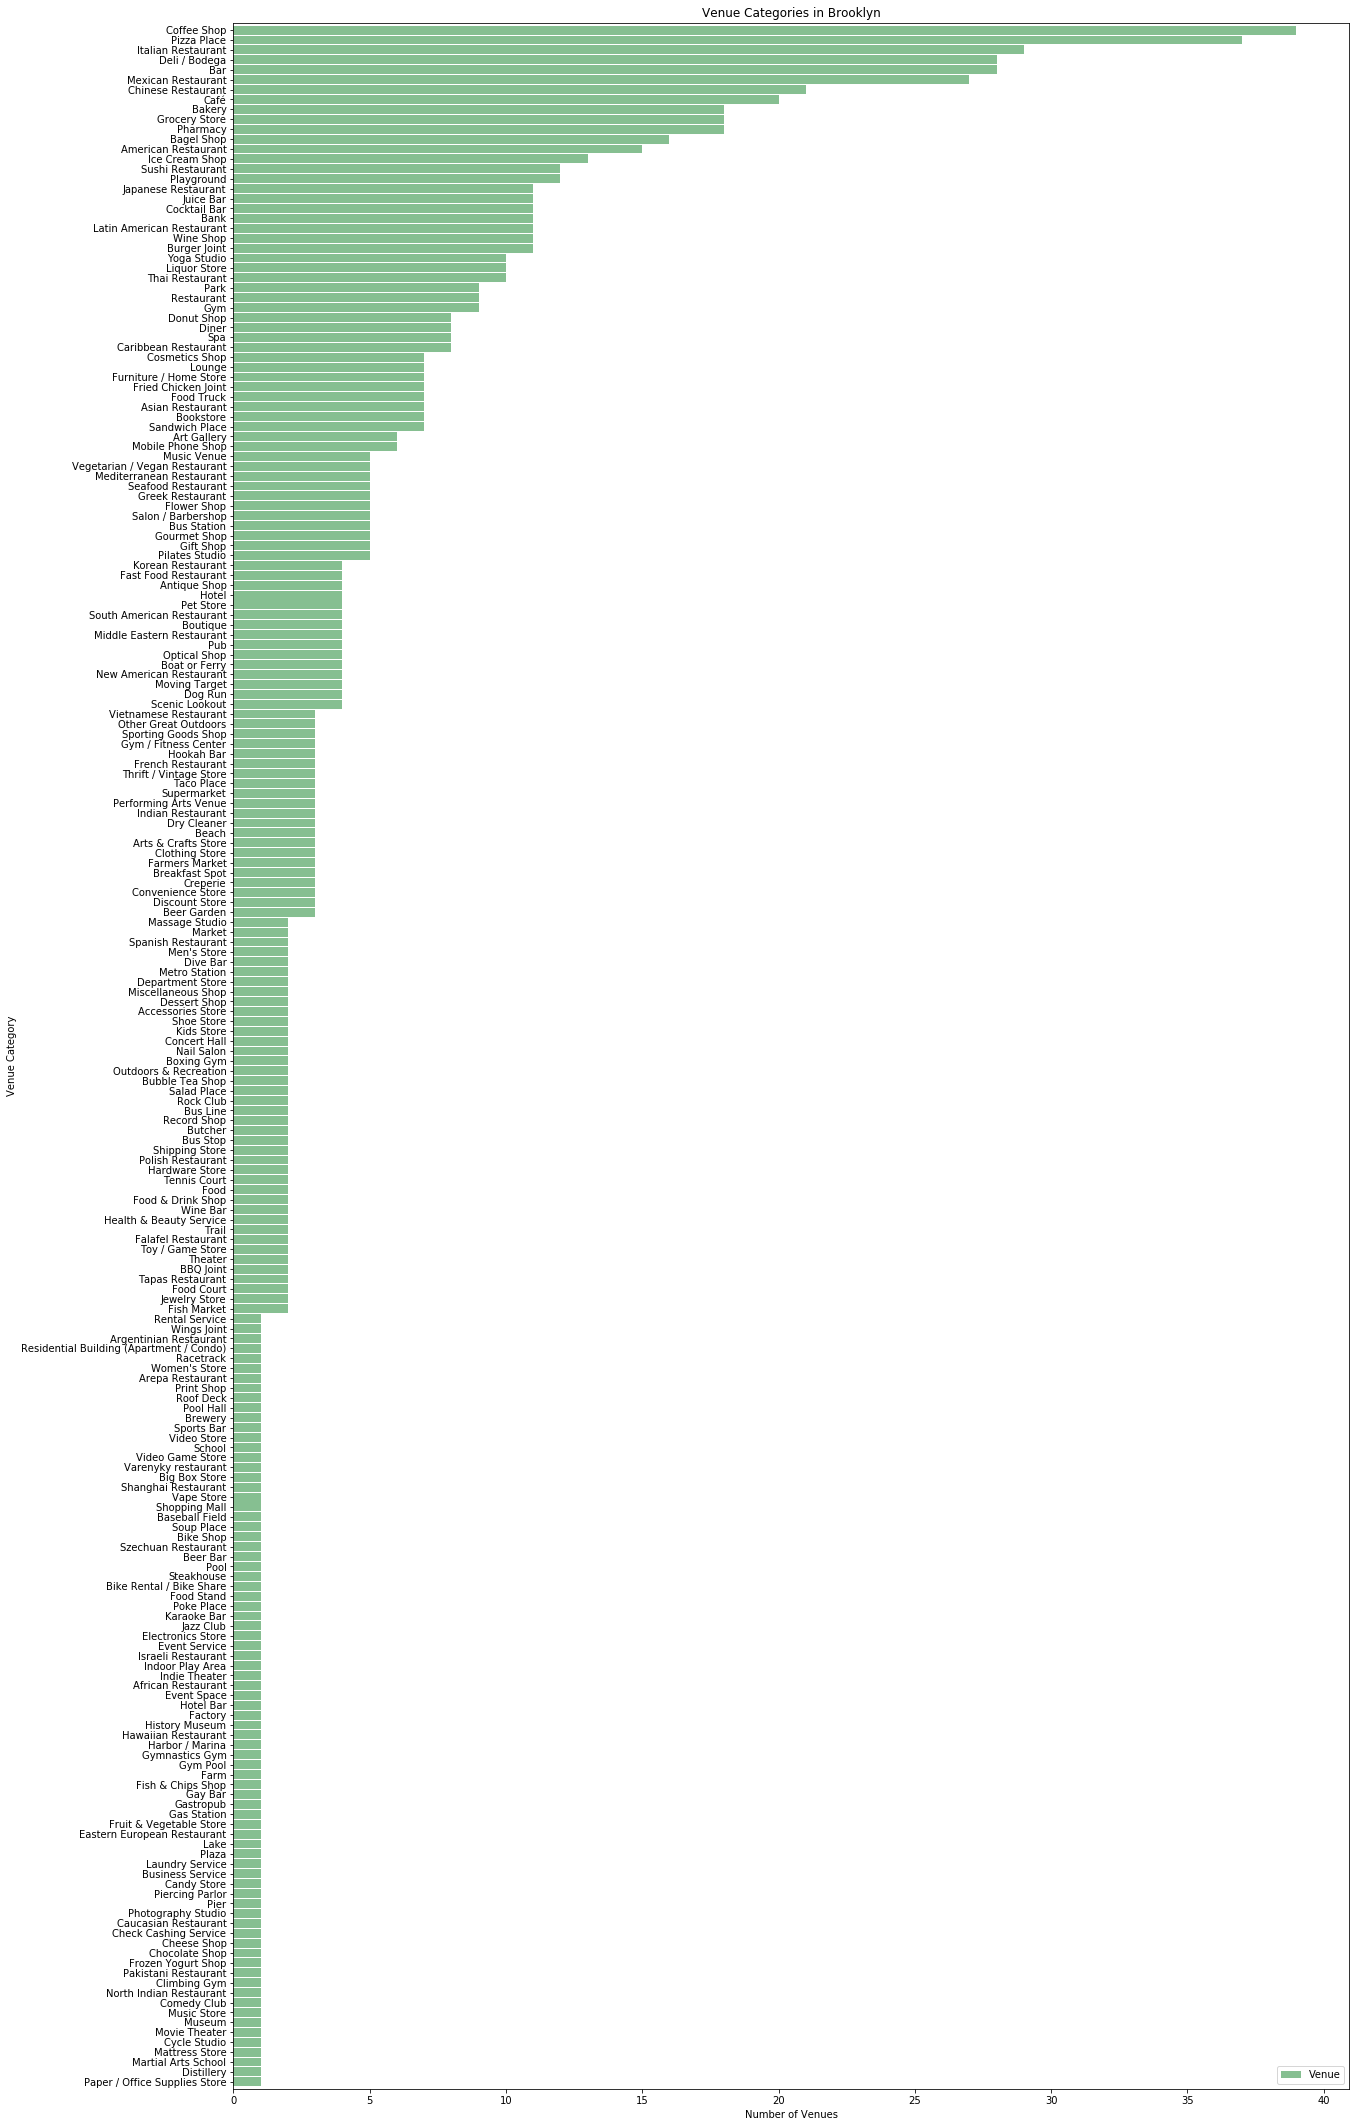

In [114]:
# Display the venue categories in a horizontal bar chart
import matplotlib.pyplot as plt

ax = brooklyn_categories_grouped.plot(kind='barh', figsize=(20, 38), color='#86bf91', zorder=2, width=0.9)
ax.set_ylabel('Venue Category')
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Number of Venues')
ax.set_title('Venue Categories in Brooklyn')

plt.show()

In [115]:
print('There are {} unique categories.'.format(len(brooklyn_venues['Venue Category'].unique())))

There are 208 unique categories.


In [116]:
brooklyn_categories_grouped_transport = brooklyn_categories_grouped.loc[['Bus Station', 'Bus Line', 'Metro Station', 'Bus Stop', 'Train Station','Light Rail Station']]
brooklyn_categories_grouped_transport

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  if __name__ == '__main__':


,Venue
Venue Category,
Bus Station,5.0
Bus Line,2.0
Metro Station,2.0
Bus Stop,2.0
Train Station,NaN
Light Rail Station,NaN


In [117]:
brooklyn_categories_grouped_outdoors = brooklyn_categories_grouped.loc[['Trail', 'Park', 'Scenic Lookout', 'Playground', 'Garden', 'Other Great Outdoors', 'Outdoors & Recreation', 'Beach']]
brooklyn_categories_grouped_outdoors.dropna(axis='rows', inplace=True)
brooklyn_categories_grouped_outdoors

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  if __name__ == '__main__':


,Venue
Venue Category,
Trail,2.0
Park,9.0
Scenic Lookout,4.0
Playground,12.0
Other Great Outdoors,3.0
Outdoors & Recreation,2.0
Beach,3.0


In [118]:
# one hot encoding
brooklyn_onehot = pd.get_dummies(brooklyn_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
brooklyn_onehot['Neighborhood'] = brooklyn_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [brooklyn_onehot.columns[-1]] + list(brooklyn_onehot.columns[:-1])
brooklyn_onehot = brooklyn_onehot[fixed_columns]

brooklyn_onehot.head()

,Neighborhood,Accessories Store,African Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Beach,Beer Bar,Beer Garden,Big Box Store,Bike Rental / Bike Share,Bike Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Candy Store,Caribbean Restaurant,Caucasian Restaurant,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Cycle Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distillery,Dive Bar,Dog Run,Donut Shop,Dry Cleaner,Eastern European Restaurant,Electronics Store,Event Service,Event Space,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gas Station,Gastropub,Gay Bar,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,History Museum,Hookah Bar,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Theater,Indoor Play Area,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Lake,Latin American Restaurant,Laundry Service,Liquor Store,Lounge,Market,Martial Arts School,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Movie Theater,Moving Target,Museum,Music Store,Music Venue,Nail Salon,New American Restaurant,North Indian Restaurant,Optical Shop,Other Great Outdoors,Outdoors & Recreation,Pakistani Restaurant,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Store,Pharmacy,Photography Studio,Pier,Piercing Parlor,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Pool Hall,Print Shop,Pub,Racetrack,Record Shop,Rental Service,Residential Building (Apartment / Condo),Restaurant,Rock Club,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shopping Mall,Soup Place,South American Restaurant,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Steakhouse,Supermarket,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tapas Restaurant,Tennis Court,Thai Restaurant,Theater,Thrift / Vintage Store,Toy / Game Store,Trail,Vape Store,Varenyky restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Bay Ridge,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Bay Ridge,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Bay Ridge,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [119]:
brooklyn_onehot.shape

(921, 209)

In [120]:
brooklyn_grouped = brooklyn_onehot.groupby('Neighborhood').mean().reset_index()
brooklyn_grouped

,Neighborhood,Accessories Store,African Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Beach,Beer Bar,Beer Garden,Big Box Store,Bike Rental / Bike Share,Bike Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Candy Store,Caribbean Restaurant,Caucasian Restaurant,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Cycle Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distillery,Dive Bar,Dog Run,Donut Shop,Dry Cleaner,Eastern European Restaurant,Electronics Store,Event Service,Event Space,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gas Station,Gastropub,Gay Bar,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,History Museum,Hookah Bar,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Theater,Indoor Play Area,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Lake,Latin American Restaurant,Laundry Service,Liquor Store,Lounge,Market,Martial Arts School,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Movie Theater,Moving Target,Museum,Music Store,Music Venue,Nail Salon,New American Restaurant,North Indian Restaurant,Optical Shop,Other Great Outdoors,Outdoors & Recreation,Pakistani Restaurant,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Store,Pharmacy,Photography Studio,Pier,Piercing Parlor,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Pool Hall,Print Shop,Pub,Racetrack,Record Shop,Rental Service,Residential Building (Apartment / Condo),Restaurant,Rock Club,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shopping Mall,Soup Place,South American Restaurant,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Steakhouse,Supermarket,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tapas Restaurant,Tennis Court,Thai Restaurant,Theater,Thrift / Vintage Store,Toy / Game Store,Trail,Vape Store,Varenyky restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Bath Beach,0.000000,0.0,0.000000,0.000000,0.00,0.0,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.0,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.090909,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.0000,0.000000,0.000000,0.0000,0.00,0.000000,0.00,0.000000,0.090909,0.000000,0.0000,0.00000,0.000000,0.090909,0.0000,0.00,0.00,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00,0.000000,0.090909,0.00,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.090909,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00,0.000000,0.00,0.000000,0.00,0.090909,0.000000,0.000000,0.090909,0.000000,0.000000,0.000,0.000000,0.090909,0.000000,0.0,0.00,0.000000,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.090909,0.000000,0.000000,0.000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000

In [121]:
brooklyn_grouped.shape

(67, 209)

In [122]:
num_top_venues = 5

for hood in brooklyn_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = brooklyn_grouped[brooklyn_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Bath Beach----
                   venue  freq
0             Donut Shop  0.09
1     Italian Restaurant  0.09
2            Pizza Place  0.09
3         Ice Cream Shop  0.09
4  Check Cashing Service  0.09


----Bay Ridge----
                      venue  freq
0        Italian Restaurant  0.12
1                       Spa  0.08
2          Greek Restaurant  0.08
3  Mediterranean Restaurant  0.08
4               Pizza Place  0.08


----Bedford Stuyvesant----
                venue  freq
0         Coffee Shop  0.33
1  Italian Restaurant  0.17
2           Juice Bar  0.17
3            Boutique  0.17
4                Café  0.17


----Bensonhurst----
                  venue  freq
0    Italian Restaurant  0.67
1                  Park  0.33
2     Accessories Store  0.00
3  Pakistani Restaurant  0.00
4         Moving Target  0.00


----Boerum Hill----
                    venue  freq
0  Furniture / Home Store  0.10
1       Indian Restaurant  0.05
2  Thrift / Vintage Store  0.05
3              Kids St

              venue  freq
0      Liquor Store  0.12
1          Pharmacy  0.12
2  Indoor Play Area  0.12
3    Ice Cream Shop  0.12
4     Deli / Bodega  0.12


----Midwood----
               venue  freq
0        Bus Station   1.0
1  Accessories Store   0.0
2         Poke Place   0.0
3      Moving Target   0.0
4             Museum   0.0


----Mill Basin----
                 venue  freq
0           Bagel Shop  0.29
1        Deli / Bodega  0.14
2        Grocery Store  0.14
3  Japanese Restaurant  0.14
4          Pizza Place  0.14


----Mill Island----
                   venue  freq
0                   Pool   1.0
1      Accessories Store   0.0
2  Outdoors & Recreation   0.0
3          Movie Theater   0.0
4          Moving Target   0.0


----New Lots----
                venue  freq
0  Chinese Restaurant   0.5
1                Bank   0.5
2   Accessories Store   0.0
3       Moving Target   0.0
4              Museum   0.0


----North Side----
                           venue  freq
0             

In [123]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = brooklyn_grouped['Neighborhood']

for ind in np.arange(brooklyn_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(brooklyn_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bath Beach,Ice Cream Shop,Check Cashing Service,Italian Restaurant,Liquor Store,Gas Station,Flower Shop,Donut Shop,Diner,Pizza Place,Hookah Bar
1,Bay Ridge,Italian Restaurant,Mediterranean Restaurant,Pizza Place,Spa,Greek Restaurant,Optical Shop,Sushi Restaurant,Bookstore,Lounge,Pool Hall
2,Bedford Stuyvesant,Coffee Shop,Boutique,Italian Restaurant,Café,Juice Bar,Yoga Studio,Factory,Food,Flower Shop,Fish Market
3,Bensonhurst,Italian Restaurant,Park,Yoga Studio,Event Service,Food,Flower Shop,Fish Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market
4,Boerum Hill,Furniture / Home Store,Pharmacy,Thrift / Vintage Store,Men's Store,Middle Eastern Restaurant,French Restaurant,Spa,Kids Store,Sushi Restaurant,Cocktail Bar


### K-Means Clustering of New York City neighborhoods

In [124]:
# set number of clusters
kclusters = 5

brooklyn_grouped_clustering = brooklyn_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(brooklyn_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [125]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

brooklyn_merged = brooklyn_data

# merge nyc_grouped with df_nyc to add latitude/longitude for each neighborhood
brooklyn_merged = brooklyn_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

brooklyn_merged.head() # check the last columns!

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Brooklyn,Bay Ridge,40.625801,-74.030621,1.0,Italian Restaurant,Mediterranean Restaurant,Pizza Place,Spa,Greek Restaurant,Optical Shop,Sushi Restaurant,Bookstore,Lounge,Pool Hall
1,Brooklyn,Bensonhurst,40.611009,-73.995180,1.0,Italian Restaurant,Park,Yoga Studio,Event Service,Food,Flower Shop,Fish Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market
2,Brooklyn,Sunset Park,40.645103,-74.010316,1.0,Pizza Place,Bank,Pharmacy,Mobile Phone Shop,Creperie,Mexican Restaurant,Breakfast Spot,Fried Chicken Joint,Latin American Restaurant,Ice Cream Shop
3,Brooklyn,Greenpoint,40.730201,-73.954241,1.0,Grocery Store,Mexican Restaurant,Spa,Coffee Shop,Bar,Café,Yoga Studio,French Restaurant,Laundry Service,Flower Shop
4,Brooklyn,Gravesend,40.595260,-73.973471,1.0,Italian Restaurant,Deli / Bodega,Pizza Place,Pharmacy,Lounge,Bakery,Baseball Field,Event Space,Flower Shop,Fish Market


In [126]:
brooklyn_merged.shape

(70, 15)

In [127]:
brooklyn_merged.dropna(inplace=True)
brooklyn_merged.shape

(67, 15)

In [128]:
brooklyn_merged_final = brooklyn_merged.astype({'Cluster Labels': 'int32'}, copy=True, errors='ignore', inplace=True)
brooklyn_merged_final

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Brooklyn,Bay Ridge,40.625801,-74.030621,1,Italian Restaurant,Mediterranean Restaurant,Pizza Place,Spa,Greek Restaurant,Optical Shop,Sushi Restaurant,Bookstore,Lounge,Pool Hall
1,Brooklyn,Bensonhurst,40.611009,-73.995180,1,Italian Restaurant,Park,Yoga Studio,Event Service,Food,Flower Shop,Fish Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market
2,Brooklyn,Sunset Park,40.645103,-74.010316,1,Pizza Place,Bank,Pharmacy,Mobile Phone Shop,Creperie,Mexican Restaurant,Breakfast Spot,Fried Chicken Joint,Latin American Restaurant,Ice Cream Shop
3,Brooklyn,Greenpoint,40.730201,-73.954241,1,Grocery Store,Mexican Restaurant,Spa,Coffee Shop,Bar,Café,Yoga Studio,French Restaurant,Laundry Service,Flower Shop
4,Brooklyn,Gravesend,40.595260,-73.973471,1,Italian Restaurant,Deli / Bodega,Pizza Place,Pharmacy,Lounge,Bakery,Baseball Field,Event Space,Flower Shop,Fish Market
5,Brooklyn,Brighton Beach,40.576825,-73.965094,1,Sushi Restaurant,Restaurant,Gourmet Shop,Market,Diner,Playground,Other Great Outdoors,Optical Shop,Coffee Shop,Eastern European Restaurant
6,Brooklyn,Sheepshead Bay,40.586890,-73.943186,2,Lake,Food Court,Food,Flower Shop,Fish Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant
7,Brooklyn,Manhattan Terrace,40.614433,-73.957438,1,Jazz Club,Dog Run,Yoga Studio,Event Service,Food,Flower Shop,Fish Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market
8,Brooklyn,Flatbush,40.636326,-73.958401,1,Juice Bar,Caribbean Restaurant,Gym,Yoga Studio,Event Space,Food,Flower Shop,Fish Market,Fish & Chips Shop,Fast Food Restaurant
9,Brooklyn,Crown Heights,40.670829,-73.943291,1,Pizza Place,Coffee Shop,Moving Target,Burger Joint,Fried Chicken Joint,Café,Supermarket,Salon / Barbershop,Museum,Spa


In [138]:
# create map
brooklyn_map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(brooklyn_merged_final['Latitude'], brooklyn_merged_final['Longitude'], brooklyn_merged_final['Neighborhood'], brooklyn_merged_final['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(brooklyn_map_clusters)
       
brooklyn_map_clusters

# Analysis of Brooklyn's neighborhoods

In [130]:
brooklyn_cleanedup = brooklyn_merged_final.sort_values(by=['Cluster Labels'])
brooklyn_cleanedup

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
31,Brooklyn,Manhattan Beach,40.577914,-73.943537,0,Ice Cream Shop,Bus Stop,Harbor / Marina,Beach,Event Space,Food,Flower Shop,Fish Market,Fish & Chips Shop,Fast Food Restaurant
59,Brooklyn,Paerdegat Basin,40.631318,-73.902335,0,Beach,Yoga Studio,Food Stand,Food & Drink Shop,Food,Flower Shop,Fish Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market
34,Brooklyn,Borough Park,40.633131,-73.990498,1,Bank,Café,Restaurant,Event Service,Food,Flower Shop,Fish Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market
35,Brooklyn,Dyker Heights,40.619219,-74.019314,1,Deli / Bodega,Italian Restaurant,Liquor Store,Burger Joint,Bagel Shop,Dog Run,Mexican Restaurant,Pet Store,Dive Bar,Food Court
37,Brooklyn,Marine Park,40.609748,-73.931344,1,Ice Cream Shop,Chinese Restaurant,Indoor Play Area,Liquor Store,Pharmacy,Pizza Place,Cosmetics Shop,Deli / Bodega,Arts & Crafts Store,Food Truck
38,Brooklyn,Clinton Hill,40.693229,-73.967843,1,Mexican Restaurant,Restaurant,Thai Restaurant,Italian Restaurant,Juice Bar,Rental Service,Pub,Pizza Place,Pet Store,Optical Shop
40,Brooklyn,Downtown,40.690844,-73.983463,1,Coffee Shop,Burger Joint,Ice Cream Shop,Department Store,Restaurant,Residential Building (Apartment / Condo),Café,Caribbean Restaurant,Polish Restaurant,Cheese Shop
41,Brooklyn,Boerum Hill,40.685683,-73.983748,1,Furniture / Home Store,Pharmacy,Thrift / Vintage Store,Men's Store,Middle Eastern Restaurant,French Restaurant,Spa,Kids Store,Sushi Restaurant,Cocktail Bar
42,Brooklyn,Prospect Lefferts Gardens,40.658420,-73.954899,1,Pizza Place,Wine Shop,Music Venue,Café,Event Service,Flower Shop,Fish Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market
43,Brooklyn,Ocean Hill,40.678403,-73.913068,1,Deli / Bodega,Chinese Restaurant,Bus Line,Dry Cleaner,African Restaurant,Metro Station,Convenience Store,Coffee Shop,Farm,Farmers Market


Get more information about each cluster:

In [131]:
# Check out cluster 1
brooklyn_merged_final.loc[brooklyn_merged_final['Cluster Labels'] == 0, brooklyn_merged_final.columns[[1] + list(range(5, brooklyn_merged_final.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
31,Manhattan Beach,Ice Cream Shop,Bus Stop,Harbor / Marina,Beach,Event Space,Food,Flower Shop,Fish Market,Fish & Chips Shop,Fast Food Restaurant
59,Paerdegat Basin,Beach,Yoga Studio,Food Stand,Food & Drink Shop,Food,Flower Shop,Fish Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market


#### Distinguishing characteristics of cluster 1 (red)
1. Comprising of only 2 neighborhoods: Manhattan Beach and Paerdegat Basin 
2. Foursquare returned 4 venues for Manhattan Beach: Beach, Ice Cream Shop, Bus Stop, Harbor / Marina. 
3. Foursquare returned only 1 venue for Paerdegat Basin: 'Manhattan Beach' with the category 'Beach'. 
4. The similarities of these 2 neighborhoods seem to come from the 'Beach' category. 

In [132]:
# Check out cluster 2
brooklyn_merged_final.loc[brooklyn_merged_final['Cluster Labels'] == 1, brooklyn_merged_final.columns[[1] + list(range(5, brooklyn_merged_final.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bay Ridge,Italian Restaurant,Mediterranean Restaurant,Pizza Place,Spa,Greek Restaurant,Optical Shop,Sushi Restaurant,Bookstore,Lounge,Pool Hall
1,Bensonhurst,Italian Restaurant,Park,Yoga Studio,Event Service,Food,Flower Shop,Fish Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market
2,Sunset Park,Pizza Place,Bank,Pharmacy,Mobile Phone Shop,Creperie,Mexican Restaurant,Breakfast Spot,Fried Chicken Joint,Latin American Restaurant,Ice Cream Shop
3,Greenpoint,Grocery Store,Mexican Restaurant,Spa,Coffee Shop,Bar,Café,Yoga Studio,French Restaurant,Laundry Service,Flower Shop
4,Gravesend,Italian Restaurant,Deli / Bodega,Pizza Place,Pharmacy,Lounge,Bakery,Baseball Field,Event Space,Flower Shop,Fish Market
5,Brighton Beach,Sushi Restaurant,Restaurant,Gourmet Shop,Market,Diner,Playground,Other Great Outdoors,Optical Shop,Coffee Shop,Eastern European Restaurant
7,Manhattan Terrace,Jazz Club,Dog Run,Yoga Studio,Event Service,Food,Flower Shop,Fish Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market
8,Flatbush,Juice Bar,Caribbean Restaurant,Gym,Yoga Studio,Event Space,Food,Flower Shop,Fish Market,Fish & Chips Shop,Fast Food Restaurant
9,Crown Heights,Pizza Place,Coffee Shop,Moving Target,Burger Joint,Fried Chicken Joint,Café,Supermarket,Salon / Barbershop,Museum,Spa
10,East Flatbush,Food & Drink Shop,Liquor Store,Pharmacy,Print Shop,Chinese Restaurant,Moving Target,Fast Food Restaurant,Food,Supermarket,Department Store


#### Distinguishing characteristics of cluster 2 (purple)
1. Comprising of 61 neighborhoods, the great majority of all neighborhoods in Brooklyn.
2. The most common venues are in the 'Food' and 'Shop & Service' categories: Restaurants of various cuisines, stores and shops offering different products. 

In [133]:
# Check out cluster 3
brooklyn_merged_final.loc[brooklyn_merged_final['Cluster Labels'] == 2, brooklyn_merged_final.columns[[1] + list(range(5, brooklyn_merged_final.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,Sheepshead Bay,Lake,Food Court,Food,Flower Shop,Fish Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant


#### Distinguishing characteristics of cluster 3 (blue)
1. Comprising of only 1 neighborhood: Sheepshead Bay
2. Foursquare returned only 1 venue for this neighborhood: 'Emmons Avenue' with the category 'Lake'. 

In [134]:
# Check out cluster 4
brooklyn_merged_final.loc[brooklyn_merged_final['Cluster Labels'] == 3, brooklyn_merged_final.columns[[1] + list(range(5, brooklyn_merged_final.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
46,Midwood,Bus Station,Yoga Studio,Deli / Bodega,Food & Drink Shop,Food,Flower Shop,Fish Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market
68,Madison,Bus Station,Yoga Studio,Deli / Bodega,Food & Drink Shop,Food,Flower Shop,Fish Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market


#### Distinguishing characteristics of cluster 4 (green)
1. Comprising of only 2 neighborhoods: Midwood and Madison
2. The top 10 most common venues are exactly the same, for instance: Bus station, yoga studio, frozen yogurt shop, etc.
3. Checking the venues returned by Foursquare, both Midwood and Madison only had 1 venue each: 'Bus station'. This accounts for them being clustered together.

In [135]:
# Check out cluster 5
brooklyn_merged_final.loc[brooklyn_merged_final['Cluster Labels'] == 4, brooklyn_merged_final.columns[[1] + list(range(5, brooklyn_merged_final.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
52,Ocean Parkway,Outdoors & Recreation,Hotel Bar,Food,Flower Shop,Fish Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant


#### Distinguishing characteristics of cluster 5 (orange)
1. Comprising of only 1 neighborhood: Ocean Parkway.
2. Foursquare returned 1 venue: 'Sour hour' with the category 'Outdoors & Recreation'. 